<a href="https://colab.research.google.com/github/GarettGazay/ai_projects/blob/master/RBSeq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Understand the predictions better, what are are these vectors it returns? A: They are the model's attempt at becoming the target.

1. Verify the input and target data are in fact the same data with the input shuffled and the target in the correct order.

2. Use the padding function to pad each batch to the correct dims (125,12)

3. Take 2 random days out of the data and convert it into a validation set, then try to implement early stopping.

4. Mini-batch train so the model can learn more and perhaps become better at predictions.

5. If training on more data does not improve the model, try looking at the data to see if there should be more, different, or less.

### Prediction

- Correlate the predicted values with the input dataframe with headers, try to place the input data in order in a df with the predictions.

- Find the most closely related (prediction, rides) values and arrange them according to the prediction order.

- Walk through by creating a loop where we check for highest similarity between each ride in input_data and the predictions. Then order the rides in line with the predictions that way so it finds the most similar ride in inputs starting at the top of the predictions list.

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time

In [4]:
rides = pd.read_csv('/content/ordering_dataset.csv')

In [5]:
rides = rides.drop(['Unnamed: 0',
                    'order',
                    'rider.first_name',
                    'rider.last_name',
                    'pickup.event_location.address1',
                    'dropoff.event_location.address1',
                    'run_name_id',
                    'pickup_time',
                    ], axis=1)

In [6]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [7]:
rides = rides.astype('float32')

In [8]:
# Count the number of NaN values in each column
nan_counts = rides.isna().sum()

# Display the count of NaN values for each column
print(nan_counts)

space_type                          0
billable_distance                   1
run_name                            0
rider.mediroutes_rider_id           0
pickup.event_location.zip           0
pickup.event_location.longitude     1
pickup.event_location.latitude      1
dropoff.event_location.zip          0
dropoff.event_location.longitude    1
dropoff.event_location.latitude     1
pickup_month                        1
pickup_day                          1
pickup_hour                         1
pickup_minute                       1
dtype: int64


In [9]:
rides.fillna(0, inplace=True)

In [10]:
rides.dtypes

space_type                          float32
billable_distance                   float32
run_name                            float32
rider.mediroutes_rider_id           float32
pickup.event_location.zip           float32
pickup.event_location.longitude     float32
pickup.event_location.latitude      float32
dropoff.event_location.zip          float32
dropoff.event_location.longitude    float32
dropoff.event_location.latitude     float32
pickup_month                        float32
pickup_day                          float32
pickup_hour                         float32
pickup_minute                       float32
dtype: object

In [11]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_month,pickup_day,pickup_hour,pickup_minute
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,1.0,1.0,0.173913,0.517241
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,1.0,1.0,0.217391,0.517241
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,1.0,1.0,0.304348,0.206897
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,1.0,1.0,0.347826,0.517241


In [12]:
counts = rides.groupby(['pickup_month', 'pickup_day']).size().reset_index(name='counts')
counts['counts'].mean()

99.41875

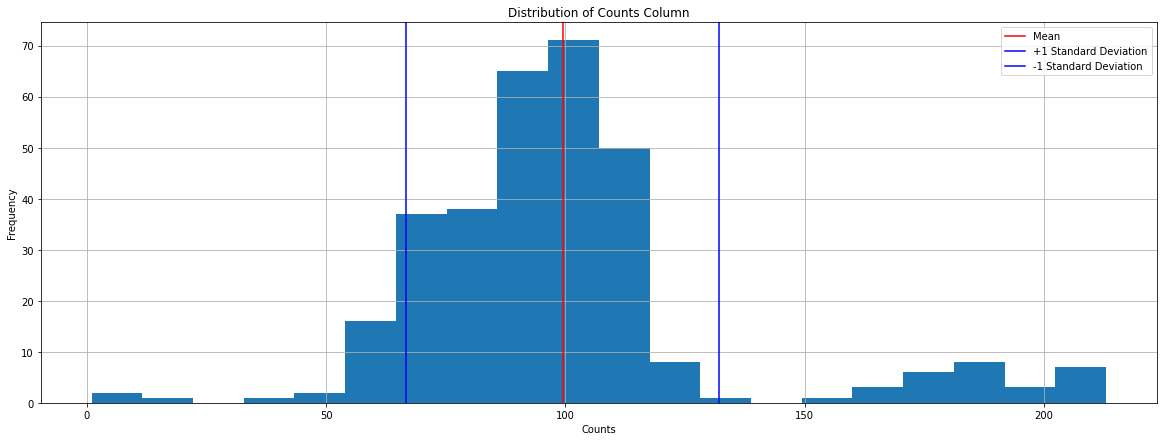

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))

import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of the counts column
mean = counts['counts'].mean()
std = counts['counts'].std()

# Plot the histogram of the counts column
counts['counts'].hist(bins=20)

# Add vertical lines to indicate mean and standard deviation
plt.axvline(mean, color='red', label='Mean')
plt.axvline(mean + std, color='blue', label='+1 Standard Deviation')
plt.axvline(mean - std, color='blue', label='-1 Standard Deviation')

# Add title and labels
plt.title('Distribution of Counts Column')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

In [14]:
rides['pickup_day'] = rides['pickup_day'].fillna(0).astype(int)
rides['pickup_month'] = rides['pickup_month'].fillna(0).astype(int)

rides['pickup_day'] = rides['pickup_day'].astype(str)
rides['pickup_month'] = rides['pickup_month'].astype(str)

rides['id'] = rides['pickup_month'] + rides['pickup_day']

rides = rides.drop(['pickup_month','pickup_day'], axis=1)

In [15]:
rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute,id
0,0.857143,0.012314,0.10,0.169343,0.583333,-0.990825,0.848788,0.837838,-0.990424,0.848616,0.173913,0.517241,11
1,0.857143,0.006394,0.10,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241,11
2,0.857143,0.003826,0.10,0.167883,0.833333,-0.990800,0.846893,0.797297,-0.990674,0.847189,0.217391,0.517241,11
3,0.285714,0.023389,0.05,0.202920,0.791667,-0.990521,0.846884,0.675676,-0.989395,0.845235,0.304348,0.206897,11
4,0.285714,0.018819,0.05,0.084672,0.750000,-0.989852,0.847646,0.729730,-0.989807,0.845745,0.347826,0.517241,11


In [16]:
rides.shape

(31814, 13)

In [17]:
rides = rides.astype(str)

In [18]:
rides.values[0].astype('float32')

array([ 0.85714287,  0.01231362,  0.1       ,  0.16934307,  0.5833333 ,
       -0.9908254 ,  0.8487879 ,  0.8378378 , -0.9904242 ,  0.8486156 ,
        0.17391305,  0.51724136, 11.        ], dtype=float32)

Put rides into buckets by date

In [19]:
# Group the rows by the 'id' column
grouped = rides.groupby('id')

# Create a list to store the grouped arrays
day_buckets = []

# Loop through each group
for name, group in grouped:
    # Convert the group to a numpy array
    group_array = group.values.astype(np.float32)
    
    # Append the group array to the list of grouped arrays
    day_buckets.append(group_array)

# Set the display format of the numpy arrays
np.set_printoptions(precision=6, suppress=True)

# Sort the list of grouped arrays by the first column of each array
day_buckets.sort(key=lambda x: x[0][1])


In [20]:
# Do this or when you shuffle below it will shuffle both for some fucking reason, and copy doesn't work.
day_buckets_y = [x.astype(str) for x in day_buckets[1:]]

In [21]:
day_buckets_y[0][0]

array(['0.2857143', '0.0032280714', '0.2', '0.13868614', '0.6805556',
       '-0.990954', '0.8473343', '0.7972973', '-0.99070346', '0.84737885',
       '0.17391305', '0.25862068', '913.0'], dtype='<U32')

In [22]:
def shuffle_np_array(np_array_list):
    for i in range(len(np_array_list)):
        np.random.shuffle(np_array_list[i])
    return np_array_list

day_buckets_X = shuffle_np_array(day_buckets)[1:] # create a shuffled version for X below

Below each 'word' is represented by a vector in the sentence we are trying to predict the order of.

In [23]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# X = []
# y = []
# max_length = 12
# # Convert the input data into a 3D array of shape (num_samples, max_length, num_features)
# for i in day_buckets_X:
#   X.append(pad_sequences(i, maxlen=max_length, dtype='float32', padding='post', truncating='post'))
# for i in day_buckets_y:
#   y.append(pad_sequences(i, maxlen=max_length, dtype='float32', padding='post', truncating='post'))

# space_type 0
# billable_distance 1
# run_name 2
# rider.mediroutes_rider_id 3
# pickup.event_location.zip 4
# pickup.event_location.longitude 5
# pickup.event_location.latitude 6
# dropoff.event_location.zip 7
# dropoff.event_location.longitude 8
# dropoff.event_location.latitude 9
# pickup_hour	pickup_minute 10
# id 11


In [24]:
input = []
target = []
for array in day_buckets_X:
    new_array = np.delete(array, -1, axis=1)
    input.append(new_array.astype('float32'))

count = 0
for array in day_buckets_y:
    new_array = np.delete(array, -1, axis=1)
    target.append(new_array.astype('float32'))


In [25]:
def pad_array(arr):
    padding = np.zeros((1, 12))
    while arr.shape[0] < 125:
        arr = np.concatenate((arr, padding), axis=0)
    return arr
input[0] = pad_array(input[0])
target[0] = pad_array(target[0])

In [26]:
# The error message suggests that the model is expecting 2 inputs, but only 1 input tensor was provided for validation data. 
# To resolve this issue, make sure the input tensors for the validation data match the expected input shape and number of inputs 
# as defined in the model architecture. If the model requires multiple inputs, make sure to pass them in as a list or tuple in 
# the correct order.

def create_validation_set():

  X_val = input[-1].astype('float32')
  X_val = pad_array(X_val)

  y_val = target[-1].astype('float32')
  y_val = pad_array(y_val)

  return X_val, y_val

X_val, y_val = create_validation_set()

In [27]:
input[0]

array([[0.857143, 0.007688, 0.4     , ..., 0.846973, 0.217391, 0.517241],
       [0.857143, 0.007597, 0.35    , ..., 0.847258, 0.695652, 0.775862],
       [0.857143, 0.005848, 0.1     , ..., 0.847978, 0.565217, 0.258621],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [28]:
input_df = pd.DataFrame(input[0], columns=[
'input_space_type',
'input_billable_distance',
'input_run_name',
'input_rider.mediroutes_rider_id',
'input_pickup.event_location.zip',
'input_pickup.event_location.longitude',
'input_pickup.event_location.latitude',
'input_dropoff.event_location.zip',
'input_dropoff.event_location.longitude',
'input_dropoff.event_location.latitude',
'input_pickup_hour',
'input_pickup_minute'
])

target_df = pd.DataFrame(target[0], columns=[
'target_space_type',
'target_billable_distance',
'target_run_name',
'target_rider.mediroutes_rider_id',
'target_pickup.event_location.zip',
'target_pickup.event_location.longitude',
'target_pickup.event_location.latitude',
'target_dropoff.event_location.zip',
'target_dropoff.event_location.longitude',
'target_dropoff.event_location.latitude',
'target_pickup_hour',
'target_pickup_minute'
])

check = pd.concat([input_df, target_df], axis=1)

In [29]:
input[0][24]

array([ 0.857143,  0.022823,  0.      ,  0.290511,  0.166667, -0.993161,
        0.851034,  0.121622, -0.991972,  0.849073,  0.347826,  0.      ])

In [30]:
target[0][0]

array([ 0.285714,  0.003228,  0.2     ,  0.138686,  0.680556, -0.990954,
        0.847334,  0.797297, -0.990703,  0.847379,  0.173913,  0.258621])

In [31]:
check.to_csv('/content/check.csv')

In [32]:
input[0].shape

(125, 12)

In [33]:
target[0].shape

(125, 12)

In [34]:
# Define the input and output shape
input_shape = (125, 12)
output_shape = (125, 12)

Set the day to train on

In [35]:
input = input[0]
target = target[0]
X_val = X_val
y_val = y_val

In [36]:
y_val

array([[0.285714, 0.045571, 0.05    , ..., 0.849885, 0.173913, 0.258621],
       [0.857143, 0.004869, 0.25    , ..., 0.847379, 0.173913, 0.517241],
       [0.857143, 0.012092, 0.3     , ..., 0.848719, 0.173913, 0.775862],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [37]:
# model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/RBSeq2Seq')

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [39]:
input = input.reshape(1, *input.shape)
target = target.reshape(1, *target.shape)
X_val = X_val.reshape(1, *X_val.shape)
y_val = y_val.reshape(1, *y_val.shape)

print(input.shape)
print(target.shape)
print(X_val.shape)
print(y_val.shape)

# Define the encoder
encoder_inputs = keras.layers.Input(shape=input_shape)
encoder = keras.layers.LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = keras.layers.Input(shape=(None, 12))
decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add the attention mechanism
attention = keras.layers.Attention()([decoder_outputs, encoder_outputs])
decoder_outputs = keras.layers.Concatenate()([decoder_outputs, attention])

decoder_dense = keras.layers.Dense(12, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error')


(1, 125, 12)
(1, 125, 12)
(1, 125, 12)
(1, 125, 12)


In [40]:
#  validation_data=([X_val, y_val], y_val), the first element of the tuple, [X_val, y_val], are the inputs to the model during validation. The second element of the tuple, y_val, is the expected target output during validation.

# Train the model
history = model.fit([input, target], target, epochs=300, batch_size=16, validation_data=([X_val, y_val], y_val), callbacks=[early_stopping], verbose=2)

Epoch 1/300
1/1 - 5s - loss: 0.3481 - val_loss: 0.3414 - 5s/epoch - 5s/step
Epoch 2/300
1/1 - 0s - loss: 0.3100 - val_loss: 0.3009 - 97ms/epoch - 97ms/step
Epoch 3/300
1/1 - 0s - loss: 0.2738 - val_loss: 0.2622 - 107ms/epoch - 107ms/step
Epoch 4/300
1/1 - 0s - loss: 0.2393 - val_loss: 0.2254 - 98ms/epoch - 98ms/step
Epoch 5/300
1/1 - 0s - loss: 0.2066 - val_loss: 0.1905 - 97ms/epoch - 97ms/step
Epoch 6/300
1/1 - 0s - loss: 0.1759 - val_loss: 0.1578 - 103ms/epoch - 103ms/step
Epoch 7/300
1/1 - 0s - loss: 0.1472 - val_loss: 0.1278 - 104ms/epoch - 104ms/step
Epoch 8/300
1/1 - 0s - loss: 0.1212 - val_loss: 0.1015 - 125ms/epoch - 125ms/step
Epoch 9/300
1/1 - 0s - loss: 0.0983 - val_loss: 0.0805 - 113ms/epoch - 113ms/step
Epoch 10/300
1/1 - 0s - loss: 0.0800 - val_loss: 0.0678 - 100ms/epoch - 100ms/step
Epoch 11/300
1/1 - 0s - loss: 0.0683 - val_loss: 0.0648 - 96ms/epoch - 96ms/step
Epoch 12/300
1/1 - 0s - loss: 0.0647 - val_loss: 0.0658 - 122ms/epoch - 122ms/step
Epoch 13/300
1/1 - 0s - los

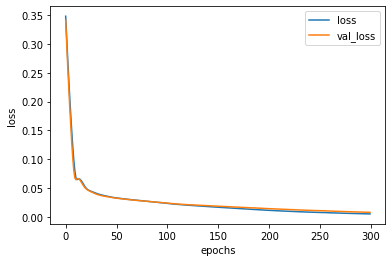

In [41]:
# Plot history (also known as a loss curve)
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

predict the vehicle for a ride by including the vehicle information in the input and target data and leaving a placeholder (e.g. zero) in place of the vehicle information at the time of prediction

In [42]:
pred = model.predict([input, target])

1/1 [==============================] - 1s 863ms/step


In [43]:
pred[0][0]

array([ 0.339028,  0.025139,  0.140312,  0.125687,  0.704658, -1.007421,
        0.826393,  0.728734, -0.988383,  0.842005,  0.188822,  0.348725],
      dtype=float32)

In [44]:
target

array([[[0.285714, 0.003228, 0.2     , ..., 0.847379, 0.173913,
         0.258621],
        [0.857143, 0.012053, 0.2     , ..., 0.848719, 0.173913,
         0.775862],
        [0.857143, 0.006394, 0.2     , ..., 0.847189, 0.217391,
         0.517241],
        ...,
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.      , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ]]])

In [45]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_cos_similiar(compare_against, pred):
  # Calculate cosine similarity between input data and predictions
  cos_similarity = cosine_similarity(compare_against, pred)

  # Get the cosine similarity value for each prediction-compare_against pair
  cosine_similarity_values = [cos_similarity[i][i] for i in range(len(cos_similarity))]

  return cosine_similarity_values

In [49]:
# Check the correlated similarity between the predictions and the targets to get a feel for the quality of training
get_cos_similiar(target[0], pred[0])

[0.9977362302451105,
 0.986442680752554,
 0.9942799342126325,
 0.9821455180194796,
 0.9892448113574778,
 0.9985000392366655,
 0.9980720989504803,
 0.9971007695446596,
 0.9828075462894341,
 0.9801727973662266,
 0.9963941120680445,
 0.9957283864278708,
 0.9918274590483073,
 0.9917685535395839,
 0.9926904985481444,
 0.9957802899908006,
 0.9835093878531176,
 0.9932303055536885,
 0.997925120099343,
 0.9956678920482213,
 0.9975978053563512,
 0.9920342850206658,
 0.9925991023045974,
 0.992056721387539,
 0.9939391858238326,
 0.9958432864975029,
 0.9952745772920876,
 0.9988861473536512,
 0.9945144616265952,
 0.9959514585398289,
 0.9905392433654793,
 0.9966398799356558,
 0.997071028384207,
 0.9957666256777663,
 0.9951621522100744,
 0.9933879162477048,
 0.9978348689980546,
 0.9898005616433768,
 0.99732086448838,
 0.9960586348961212,
 0.9917214781211213,
 0.995961615251492,
 0.9940004098157973,
 0.9933510333169014,
 0.9769294296453711,
 0.9911977864980321,
 0.9954497973057039,
 0.997913817212632,


Loop through predictions comparing the similarity between each ride in the input vector, whichever ride has the highest similarity, add to another list which is the predicted rides order.

In [67]:
from time import sleep

max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])
ordered_rides = pd.DataFrame(columns = [
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
])

for i in pred[0]:
  for j in input[0]:
    cos_similarity = cosine_similarity(i.reshape(1, -1), j.reshape(1, -1))

    # Add mapping to max finder
    row = {"pred": i, "original_input": j, "cos_similarity": cos_similarity}
    max_finder = max_finder.append(row, ignore_index=True)

  # Find the winner
  max_row_index = np.argmax(max_finder['cos_similarity'])
  most_similar = max_finder.loc[max_row_index]

  # Add most similar ride to ordered rides in order of predictions against the target
  row = {'space_type' : most_similar[1][0],
  'billable_distance' : most_similar[1][1],
  'run_name' : most_similar[1][2],
  'rider.mediroutes_rider_id' : most_similar[1][3],
  'pickup.event_location.zip' : most_similar[1][4],
  'pickup.event_location.longitude' : most_similar[1][5],
  'pickup.event_location.latitude' : most_similar[1][6],
  'dropoff.event_location.zip' : most_similar[1][7],
  'dropoff.event_location.longitude' : most_similar[1][8],
  'dropoff.event_location.latitude' : most_similar[1][9],
  'pickup_hour' : most_similar[1][10],
  'pickup_minute' : most_similar[1][11]}
  
  ordered_rides = ordered_rides.append(row, ignore_index=True)

  # Reset max finder so it starts empty for the next iteration
  max_finder = pd.DataFrame(columns=["pred", "original_input", "cos_similarity"])

In [69]:
ordered_rides.head()

,space_type,billable_distance,run_name,rider.mediroutes_rider_id,pickup.event_location.zip,pickup.event_location.longitude,pickup.event_location.latitude,dropoff.event_location.zip,dropoff.event_location.longitude,dropoff.event_location.latitude,pickup_hour,pickup_minute
0,0.285714,0.003228,0.20,0.138686,0.680556,-0.990954,0.847334,0.797297,-0.990703,0.847379,0.173913,0.258621
1,0.857143,0.012053,0.20,0.061314,0.472222,-0.991429,0.847318,0.121622,-0.991856,0.848719,0.173913,0.775862
2,0.857143,0.006394,0.20,0.182482,0.458333,-0.990922,0.846670,0.797297,-0.990674,0.847189,0.217391,0.517241
3,0.857143,0.001585,0.10,0.166423,0.680556,-0.990951,0.847336,0.675676,-0.991042,0.847346,0.434783,0.517241
4,0.857143,0.002593,0.25,0.090511,0.833333,-0.990608,0.847115,0.797297,-0.990657,0.847092,0.347826,0.258621


In [70]:
target[0]

array([[0.285714, 0.003228, 0.2     , ..., 0.847379, 0.173913, 0.258621],
       [0.857143, 0.012053, 0.2     , ..., 0.848719, 0.173913, 0.775862],
       [0.857143, 0.006394, 0.2     , ..., 0.847189, 0.217391, 0.517241],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [ ]:
target_df = pd.DataFrame(target)
ordered_input = pd.DataFrame(ordered_input)

In [ ]:
ordered_input.to_csv('/content/ordered_input.csv')

In [ ]:
target_df.to_csv('/content/target_df.csv')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cos_similarity = cosine_similarity(target[0], pred[0])


In [ ]:
pred[0][1]

In [ ]:
index = 7
x = tf.reduce_sum(tf.constant(target[0][index]))
y = tf.reduce_sum(tf.constant(pred[0][index]))
x,y

In [ ]:
target[0][1]

In [ ]:
cos_similarity[0]

In [ ]:
import pandas as pd

# Create a DataFrame containing the input data
input_df = pd.DataFrame({'input_ride': input[0]})

# Create a DataFrame containing the predictions
prediction_df = pd.DataFrame({'prediction': cos_similarity[0]})

# Add a common identifier to both DataFrames
input_df['id'] = range(1, len(input_df) + 1)
prediction_df['id'] = range(1, len(prediction_df) + 1)

# Join the DataFrames on the 'id' column
joined_df = pd.merge(input_df, prediction_df, on='id')

# Sort the joined DataFrame by the 'prediction' column
joined_df.sort_values(by='prediction', inplace=True)

# The 'input_ride' column now corresponds to the order of the predictions
ordered_input = joined_df['input_ride'].tolist()


In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

# Calculate cosine similarity between each pair of predicted and target vectors
cos_similarity = cosine_similarity(target[0], pred[0])

# Assign each predicted vector to the target with which it has the highest similarity score
assignment = np.argmax(cos_similarity, axis=1)

# # Get the ordered predictions based on the assignments
ordered_predictions = target[0][assignment]


In [ ]:
import pandas as pd

# Create a DataFrame from the ordered_predictions numpy array
prediction_df = pd.DataFrame(ordered_predictions)

# Add a column header to the dataframe for each of the prediction values
prediction_df.columns = [
  'space_type',
  'billable_distance',
  'run_name',
  'rider.mediroutes_rider_id',
  'pickup.event_location.zip',
  'pickup.event_location.longitude',
  'pickup.event_location.latitude',
  'dropoff.event_location.zip',
  'dropoff.event_location.longitude',
  'dropoff.event_location.latitude',
  'pickup_hour',
  'pickup_minute'
]

In [ ]:
prediction_df.head()

In [ ]:
# take te

In [ ]:
ordered_predictions[0]

In [ ]:
target[0][5]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))

# Plot the data as a scatter plot
plt.scatter(ordered_predictions, target[0], color='red', label='Predictions')
plt.scatter(ordered_predictions, target[0], color='blue', label='Targets')

# Add labels and title to the plot
plt.xlabel('Ordered Predictions')
plt.ylabel('Targets')
plt.title('Ordered Predictions vs Targets')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Reshape cosine similarities into 2D array
cos_similarities = cos_similarity.reshape(len(ordered_predictions), len(target[0]))

# Plot the heatmap
plt.imshow(cos_similarities, cmap='hot', aspect='auto')

# Add labels and title to the plot
plt.xlabel('Predictions')
plt.ylabel('Targets')
plt.title('Cosine Similarities between Predictions and Targets')

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
# Plot a histogram of the cosine similarity values
plt.hist(cos_similarity)

# Add labels and title to the plot
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution between Target and Ordered Predictions')

# Show the plot
plt.show()


In [ ]:
input[0].shape

In [ ]:
ordered_predictions.shape

In [ ]:
import pandas as pd

# Create a DataFrame containing the input data
input_df = pd.DataFrame({'input_data': day_buckets_X[0].tolist()})

# Create a DataFrame containing the predictions
prediction_df = pd.DataFrame({'prediction': ordered_predictions.tolist()})

# Add a common identifier to both DataFrames
input_df['id'] = range(1, len(input_df) + 1)
prediction_df['id'] = range(1, len(prediction_df) + 1)

# Join the DataFrames on the 'id' column
joined_df = pd.merge(input_df, prediction_df, on='id')

# Sort the joined DataFrame by the 'prediction' column
joined_df.sort_values(by='prediction', inplace=True)

# The 'input_data' column now corresponds to the order of the predictions
ordered_input = joined_df['input_data'].tolist()



In [ ]:
ordered_input

In [ ]:
# [
#   'space_type',
#   'billable_distance',
#   'run_name',
#   'rider.mediroutes_rider_id',
#   'pickup.event_location.zip',
#   'pickup.event_location.longitude',
#   'pickup.event_location.latitude',
#   'dropoff.event_location.zip',
#   'dropoff.event_location.longitude',
#   'dropoff.event_location.latitude',
#   'pickup_hour',
#   'pickup_minute'
# ]

# Create a DataFrame containing the input data
input_df = pd.DataFrame(day_buckets_X[0].tolist(), columns=[
'space_type',
'billable_distance',
'run_name',
'rider.mediroutes_rider_id',
'pickup.event_location.zip',
'pickup.event_location.longitude',
'pickup.event_location.latitude',
'dropoff.event_location.zip',
'dropoff.event_location.longitude',
'dropoff.event_location.latitude',
'pickup_hour',
'pickup_minute',''
])

# Create a DataFrame containing the predictions
prediction_df = pd.DataFrame({'prediction': ordered_predictions.tolist()})

# Add a common identifier to both DataFrames
input_df['id'] = range(1, len(input_df) + 1)
prediction_df['id'] = range(1, len(prediction_df) + 1)

# Join the DataFrames on the 'id' column
joined_df = pd.merge(input_df, prediction_df, on='id')

# Sort the joined DataFrame by the 'prediction' column
joined_df.sort_values(by='prediction', inplace=True)

# The joined DataFrame now contains both the input data and the predictions, ordered by the predictions
ordered_input_df = joined_df.drop(['prediction', 'id'], axis=1)



In [ ]:
ordered_input_df

In [ ]:
rides = pd.read_csv('/content/ordering_dataset.csv')
rides['id'] = rides['pickup_month'] + rides['pickup_day']

In [ ]:
import pandas as pd

# Get a list of unique values in the 'id' column
unique_ids = rides['id'].unique()

# Create a dictionary to store the individual DataFrames
df_dict = {}

# Loop through the unique values of the 'id' column
for id_value in unique_ids:
    # Filter the DataFrame to get the rows with the current 'id' value
    filtered_df = rides[rides['id'] == id_value]
    # Add the filtered DataFrame to the dictionary
    df_dict[id_value] = filtered_df

In [ ]:
df_dict[11]